In [1]:
import numpy as np
import scipy as sp
# import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import signal_generation as sg
import waveform_optimiser as wf
import channel_model as ch

from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from importlib import reload

2022-07-16 17:21:41.490501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
reload(sg)
reload(wf)
reload(ch)

In [3]:
def rrc_filter_base(t, t_symb, beta):

    one_over_ts = 1.0 / t_symb
    if t == 0.:
        return one_over_ts * (1. + beta * (4. / np.pi - 1))
    elif beta != 0. and abs(t) == 0.25 * t_symb / beta:
        return beta * one_over_ts / np.sqrt(2) * ((1. + 2. / np.pi) * np.sin(0.25 * np.pi / beta) + (1. - 2. / np.pi) * np.cos(0.25 * np.pi / beta))
    else:
        return (np.sin(np.pi * (1. - beta) * t * one_over_ts) + 4. * beta * t * one_over_ts * np.cos(np.pi * (1. + beta) * t * one_over_ts)) / \
               np.pi / (1. - (4. * beta * t * one_over_ts) ** 2)

def rrcosfilter_our(N, alpha, Ts, Fs):

    dt = 1. / float(Fs)
    t = (np.arange(N)-N / 2) * dt
    rrc = np.zeros(N, dtype=np.float)

    for k in range(N):
        try:
            rrc[k] = rrc_filter_base(t[k], Ts, alpha)
        except Exception as e:
            print('t_k = ', t[k], e)
            rrc[k] = rrc_filter_base(t[k], Ts, alpha)


    return rrc


def rrcosfilter_new(nt, beta, t_symb, sample_rate):

    one_over_ts = 1.0 / t_symb
    dt = 1. / float(sample_rate)
    t = (np.arange(nt) - nt / 2.) * dt
    rrc = np.zeros(nt, dtype=np.float)

    # found ranges for conditions
    zero_pos = np.where(np.isclose(t, 0., atol=1e-16, rtol=1e-15))
    if beta != 0:
        nodes_pos = np.where(np.isclose(abs(t), 0.25 * t_symb / beta, atol=1e-16, rtol=1e-15))
        all_pos = np.where(~(np.isclose(abs(t), 0.25 * t_symb / beta, atol=1e-16, rtol=1e-15) | np.isclose(t, 0., atol=1e-16, rtol=1e-15)))

    else:
        all_pos = np.where(~np.isclose(t, 0., atol=1e-16, rtol=1e-15))

    if beta != 0 and np.shape(nodes_pos)[1] != 0:
        nodes_values = np.ones(len(t[nodes_pos]), dtype=float) * beta * one_over_ts / np.sqrt(2) * \
                       ((1. + 2. / np.pi) * np.sin(0.25 * np.pi / beta) + (1. - 2. / np.pi) * np.cos(0.25 * np.pi / beta))
        rrc[nodes_pos] = nodes_values

    if np.shape(zero_pos)[1] != 0:
        rrc[zero_pos] = one_over_ts * (1. + beta * (4. / np.pi - 1))

    all_values = (np.sin(np.pi * (1. - beta) * t[all_pos] * one_over_ts) +
                  4. * beta * t[all_pos] * one_over_ts * np.cos(np.pi * (1. + beta) * t[all_pos] * one_over_ts)) / \
                 (np.pi * t[all_pos] * (1. - np.power(4. * beta * t[all_pos] * one_over_ts, 2)))
    rrc[all_pos] = all_values


    return rrc

In [15]:
nt_span = 2 ** 8
t_span = 32.0

t_symb = 1.0
roll_off = 0.0

dt = t_span / nt_span
t = np.array([(i - nt_span / 2) * dt for i in range(nt_span)])
w = np.array([(i - nt_span / 2) * (2. * np.pi / t_span) for i in range(nt_span)])
f = w / (2 * np.pi)

# rcos_time = np.zeros(len(t))
# rcos_spec = np.zeros(len(f))
# for k in range(len(f)):
#     rcos_spec[k] = rc_filter_freq(w[k], t_symb, roll_off)
#     rcos_time[k] = rc_filter(t[k], t_symb, roll_off)

# rcos_time = rrcosfilter_our(nt_span, roll_off, t_symb, 1 / dt)

In [17]:
fft_f = fftfreq(nt_span, d=dt)
# print(fft_f)
print(fftshift(fft_f))
print('df = ', fft_f[1] - fft_f[0], 1. / (dt * nt_span))
print(f)

[-4.      -3.96875 -3.9375  -3.90625 -3.875   -3.84375 -3.8125  -3.78125
 -3.75    -3.71875 -3.6875  -3.65625 -3.625   -3.59375 -3.5625  -3.53125
 -3.5     -3.46875 -3.4375  -3.40625 -3.375   -3.34375 -3.3125  -3.28125
 -3.25    -3.21875 -3.1875  -3.15625 -3.125   -3.09375 -3.0625  -3.03125
 -3.      -2.96875 -2.9375  -2.90625 -2.875   -2.84375 -2.8125  -2.78125
 -2.75    -2.71875 -2.6875  -2.65625 -2.625   -2.59375 -2.5625  -2.53125
 -2.5     -2.46875 -2.4375  -2.40625 -2.375   -2.34375 -2.3125  -2.28125
 -2.25    -2.21875 -2.1875  -2.15625 -2.125   -2.09375 -2.0625  -2.03125
 -2.      -1.96875 -1.9375  -1.90625 -1.875   -1.84375 -1.8125  -1.78125
 -1.75    -1.71875 -1.6875  -1.65625 -1.625   -1.59375 -1.5625  -1.53125
 -1.5     -1.46875 -1.4375  -1.40625 -1.375   -1.34375 -1.3125  -1.28125
 -1.25    -1.21875 -1.1875  -1.15625 -1.125   -1.09375 -1.0625  -1.03125
 -1.      -0.96875 -0.9375  -0.90625 -0.875   -0.84375 -0.8125  -0.78125
 -0.75    -0.71875 -0.6875  -0.65625 -0.625   -0.59

In [18]:
print(np.mean(fft_f - f))

0.0


So we found that
```
fftshift(fftfreq(nt_span, d=dt)) == np.array([(i - nt_span / 2) * (1. / t_span) for i in range(nt_span)])
```

In [20]:
N = 10
dt = 1. / N
t = (np.arange(N)-N / 2) * dt
print(t)

[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]


In [37]:
print(np.isclose(0.1 + 0.2 + 1e-15, 0.3, rtol=1e-15, atol=1e-15))
print(0.1 + 0.2 == 0.3)

True
False


In [54]:
sample_freq_ex = 1 / 128e9 / 128
print(sample_freq_ex)
print(np.isclose(0., sample_freq_ex, atol=1e-16, rtol=1e-15))

6.103515625e-14
False


Comparison of two different grids

In [169]:
dt = 0.1
t_symb = 1.0
roll_off = 0.1

nt1 = 2 ** 10
nt2 = 2 ** 12

filter1 = rrcosfilter_new(nt1, roll_off, t_symb, 1. / dt)
t1 = (np.arange(nt1) - nt1 / 2) * dt
fft_f1 = fftshift(fftfreq(nt1, d=dt))
df1 = 1. / (dt * nt1)
spec1 = fftshift(fft(filter1))

filter2 = rrcosfilter_new(nt2, roll_off, t_symb, 1. / dt)
t2 = (np.arange(nt2) - nt2 / 2) * dt
fft_f2 = fftshift(fftfreq(nt2, d=dt))
df2 = 1. / (dt * nt2)
spec2 = fftshift(fft(filter2))

print(np.shape(filter1), np.shape(t1), np.shape(fft_f1))
print(np.shape(filter2), np.shape(t2), np.shape(fft_f2))

print(fft_f1[0], fft_f1[-1], 5. - df1)
print(fft_f2[0], fft_f2[-1], 5. - df2)

f_down = downsample(fft_f2, int(nt2 / nt1))
print(f_down[0], f_down[-1], df1, f_down[1] - f_down[0])
f_ups = freq_upsample(fft_f1, nt2)
print(f_ups[0], f_ups[-1], df2, f_ups[1] - f_ups[0])

# spec_ups = upsample(spec1, nt2)
# filter_ups = fft(ifftshift(spec_ups))
# print(np.shape(filter_ups), np.max(filter_ups))

# filter_ups = upsample(filter1, nt2)
filter_ups = upsample_in_time(filter1, nt2)
spec_ups = fftshift(fft(filter_ups))

# spec_ups = upsample_interpolate(spec1, fft_f1, fft_f2[:-4], kind='cubic')
# spec_ups = np.concatenate((spec_ups, np.zeros(4)), axis=0)
# print(np.shape(spec_ups), np.shape(fft_f2))

(1024,) (1024,) (1024,)
(4096,) (4096,) (4096,)
-5.0 4.990234375 4.990234375
-5.0 4.99755859375 4.99755859375
-5.0 4.990234375 0.009765625 0.009765625
-5.0 4.99755859375 0.00244140625 0.00244140625


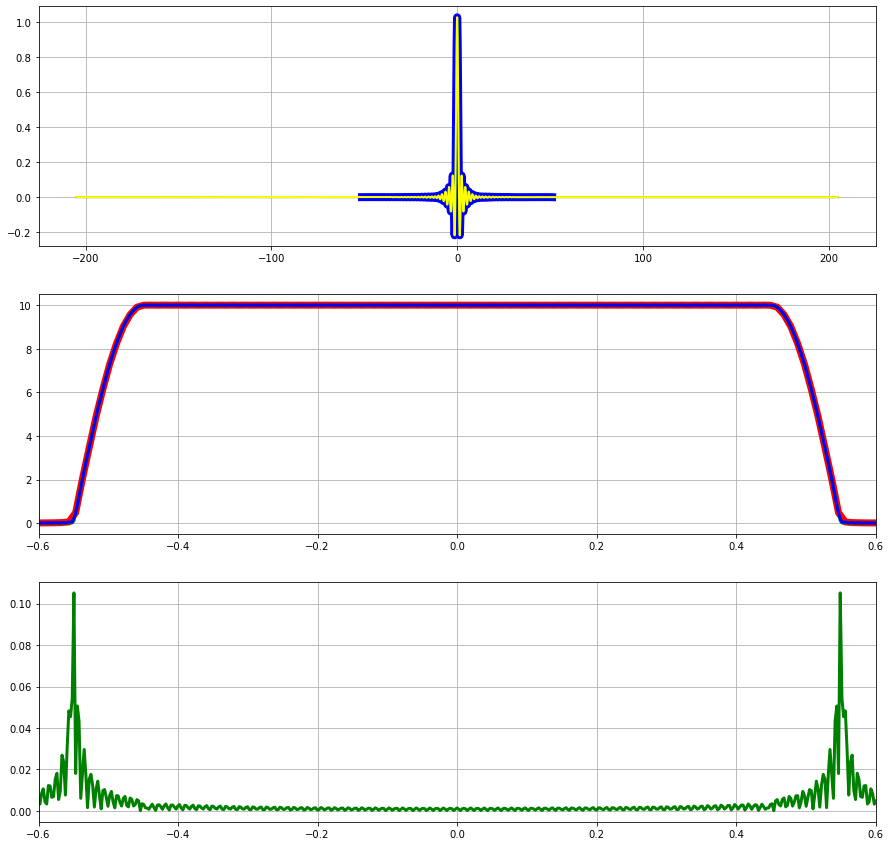

In [174]:
t_coef = 100.0
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(t1, filter1, linewidth=8, color='blue')
axs[0].plot(t2, filter2, linewidth=2, color='green')
axs[0].plot(t2, np.real(filter_ups), linewidth=2, color='yellow')
# axs[0].plot(t2, np.absolute(ifft(ifftshift(spec_ups))), linewidth=2, color='yellow')
# axs[0].set_xlim(-t_coef * t_symb, t_coef * t_symb)
axs[0].grid(True)

axs[1].plot(fft_f1, np.absolute(spec1), linewidth=7, color='red')
axs[1].plot(fft_f2, np.absolute(spec2), linewidth=3, color='green')
axs[1].plot(fft_f2, np.absolute(spec_ups), linewidth=3, color='blue')
# axs[1].set_yscale('log')
axs[1].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
axs[1].grid(True)

# axs[2].plot(fft_f2, np.absolute(np.absolute(spec2) - np.absolute(spec_ups)), linewidth=3, color='blue')
axs[2].plot(fft_f2, np.absolute(spec2 - spec_ups), linewidth=3, color='green')
# axs[1].plot(fft_f2, np.absolute(spec2), linewidth=3, color='green')
# axs[1].set_yscale('log')
axs[2].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
axs[2].grid(True)

In [168]:
from scipy.interpolate import interp1d


def downsample(spectrum, step):
    return spectrum[::step]


def freq_upsample(freq, new_size):

    n = len(freq)
    df_new = (freq[1] - freq[0]) * n / new_size
    # return np.array([freq[0] + df_new * k for k in range(new_size)])
    return np.arange(new_size) * df_new + freq[0]


def upsample(function, new_size):

    n = len(function)
    upsampling_factor = int(new_size / n)
    return np.repeat(function, upsampling_factor)


def upsample_zero(function, new_size):

    n = len(function)
    upsampling_factor = int(new_size / n)
    result = np.zeros(new_size, dtype=np.complex128)
    result[::upsampling_factor] = function
    return result


def upsample_interpolate(function, x, new_x, kind='linear'):

    f = interp1d(x, function, kind=kind)
    return f(new_x)


def upsample_in_time(f, new_size):

    n = len(f)
    zeros = np.zeros(int((new_size - n) / 2), dtype=np.complex128)
    return np.concatenate((zeros, f, zeros))

In [58]:
a = np.array([1, 2, 3, 4, 5])
print(a)
b = np.broadcast_to(a, (4, 5))
print(b)
print(b.reshape((b.shape[1] * b.shape[0]), order='F'))
print(np.repeat(a, 4))

[1 2 3 4 5]
[[1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]]
[1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]
[1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]


Polynomial multiplication

In [55]:
from scipy.fft import fft, ifft, fftshift
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow import signal
from numpy.polynomial import polynomial as pl

In [27]:
a = np.random.random(10)
print(a)

[0.36021678 0.5317356  0.09914591 0.22237074 0.0511018  0.87308747
 0.74002768 0.44646425 0.69104086 0.86596594]


In [13]:
n_test = 10000
p_order = 1000

# a = np.array([0, 0, 0, 1, 2, 3])
# b = np.array([0, 0, 0, 3, 4, 5])
# point = 1.2
# a_val = np.polyval(a, point)
# b_val = np.polyval(b, point)

start_time = datetime.now()
for k in range(n_test):
    a = np.random.random(p_order)
    b = np.random.random(p_order)
    # print(a_val * b_val)
    c = pl.polymul(a, b)
    # print(c, np.polyval(c, point))
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000
print("numpy ", execution_time, "ms")

# p1 = np.poly1d(a)
# p2 = np.poly1d(b)
# print(p1)
# print(p2)
# print(np.polymul(p1, p2))

start_time = datetime.now()
a = np.zeros(2 * p_order - 1)
b = np.zeros(2 * p_order - 1)
for k in range(n_test):
    # a[p_order - 1:] = np.random.random(p_order)
    # b[p_order - 1:] = np.random.random(p_order)
    a = np.random.random(p_order)
    b = np.random.random(p_order)

    c_via_ft = ifft(fft(a) * fft(b))
    # print(c_via_ft)
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000
print("fft ", execution_time, "ms")


numpy  2055.698 ms
fft  358.615 ms


In [ ]:
def n_coef_poly_mult():
    ...

def fast_multiple_poly_mult(poly_coefs):

    n_poly = np.shape(poly_coefs)[0]
    n_coef_poly = np.shape(poly_coefs)[1]

    n_coef_total = n_coef_poly * n_poly - n_poly + 1
    n_zeros_right = n_poly - 1
    n_zeros_left = n_coef_total - n_coef_poly


In [77]:
a = np.array([0.1j, 1 + 1j, 3 + 0.1j, -4j, 0.22j, 13j, 1.0, 2, 10, -109])
b = np.conj(a)

f_a = fft(a)
f_b = np.conj(fft(b))[::-1]


# print(fft(a))
# print(fft(b))

for k in range(len(a)):
    with np.printoptions(precision=3, suppress=True):
        print(f_a[k], f_b[k-1], abs(f_a[k] - f_b[k-1]))


(-92+10.42j) (-92+10.42j) 0.0
(-87.77568785449913-66.51108092067345j) (-87.77568785449913-66.51108092067344j) 1.4210854715202004e-14
(-42.04832969663423-85.99618003609994j) (-42.04832969663423-85.99618003609994j) 0.0
(28.236316882565575-125.41323047935374j) (28.23631688256559-125.41323047935374j) 1.4210854715202004e-14
(87.75921409372158-59.09161259714003j) (87.75921409372158-59.09161259714003j) 0.0
(120-9.580000000000005j) (120.00000000000001-9.579999999999998j) 1.5888218580782548e-14
(94.64093253376559+80.90727857474056j) (94.64093253376559+80.90727857474056j) 0.0
(21.331014014924115+92.49722461425426j) (21.331014014924108+92.49722461425424j) 2.929642751054232e-14
(-48.35181693085295+119.2605140584994j) (-48.35181693085295+119.2605140584994j) 0.0
(-81.79164304299056+44.50708678577293j) (-81.79164304299057+44.50708678577294j) 2.0097183471152322e-14


In [53]:
a = np.array([[1, 2, 3, 4], [4, 5, 6, 7], [7, 8, 9, 9]])
print(np.shape(a), a, len(a))
b = np.zeros((4, 3))
print(b)
# a[:2] = np.zeros((2, 4))
# print(np.concatenate((b, a)))
c = np.swapaxes(a, 0, 1)
print(c)
d = np.concatenate((b, c))
print(d)
print(np.swapaxes(d, 0, 1))

print(np.random.random((5, 3)))

(3, 4) [[1 2 3 4]
 [4 5 6 7]
 [7 8 9 9]] 3
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1 4 7]
 [2 5 8]
 [3 6 9]
 [4 7 9]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 4. 7.]
 [2. 5. 8.]
 [3. 6. 9.]
 [4. 7. 9.]]
[[0. 0. 0. 0. 1. 2. 3. 4.]
 [0. 0. 0. 0. 4. 5. 6. 7.]
 [0. 0. 0. 0. 7. 8. 9. 9.]]
[[0.01262777 0.27142744 0.1121153 ]
 [0.78694256 0.25936397 0.18034127]
 [0.62429616 0.5059363  0.14546927]
 [0.57639541 0.86416668 0.98328092]
 [0.20998998 0.70999154 0.35753964]]


In [13]:
a = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3])
b = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, -7, 9, 15]) + 1j * np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3])
c = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5])
d = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.1, -23])

with np.printoptions(precision=3, suppress=True):
    print(pl.polymul(a, b))
    print(ifft(fft(a) * fft(b)))

    print(pl.polymul(pl.polymul(a, b), c))
    print(ifft(fft(a) * fft(b) * fft(c)))

    print(pl.polymul(pl.polymul(pl.polymul(a, b), c), d))
    print(ifft(fft(a) * fft(b) * fft(c) * fft(d)))

[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j -7. +1.j -5. +4.j 12.+10.j 57.+12.j 45. +9.j]
[ 0. +0.j  0. +0.j  0. +0.j -0. -0.j  0. -0.j  0. +0.j -7. +1.j -5. +4.j
 12.+10.j 57.+12.j 45. +9.j -0. +0.j]
[  0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j
   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j
   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j
   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j
   0.  +0.j   0.  +0.j   0.  +0.j -35.  +5.j -60. +25.j   0. +75.j
 320.+130.j 570.+155.j 510.+105.j 225. +45.j]
[  0.  +0.j   0.  -0.j   0.  +0.j -35.  +5.j -60. +25.j   0. +75.j
 320.+130.j 570.+155.j 510.+105.j 225. +45.j   0.  +0.j   0.  +0.j]
[     0.    +0.j       0.    +0.j       0.    +0.j       0.    +0.j
      0.    +0.j       0.    +0.j       0.    +0.j       0.    +0.j
      0.    +0.j       0. 

In [10]:
a = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.5, 2.2, 3.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 9])
b = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4, -5, -6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4, -5, -6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4, -5, -6])

a_sh = np.array([1, 2, 3])
b_sh = np.array([1.5, 2.2, 3.5])
c_sh = np.array([7, 8, 9])

a_sh2 = np.array([-4, -5, -6])
b_sh2 = np.array([-4, -5, -6])
c_sh2 = np.array([-4, -5, -6])

print(pl.polymul(a_sh, a_sh2))
print(pl.polymul(b_sh, b_sh2))
print(pl.polymul(c_sh, c_sh2))
print(pl.polymul(a, b))

a = np.concatenate((np.zeros(len(a) -1), a))
b = np.concatenate((np.zeros(len(b) - 1), b))
c_via_ft = ifft(fft(a) * fft(b))
print(np.real(c_via_ft))

[ -4. -13. -28. -27. -18.]
[ -6.  -16.3 -34.  -30.7 -21. ]
[ -28.  -67. -118.  -93.  -54.]
[   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.    -4.   -13.   -28.   -27.   -18.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.   -10.
  -29.3  -62.   -57.7  -39.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.   -38.   -96.3 -180.  -150.7  -93.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.   -34.
  -83.3 -152.  -123.7  -75.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.   -28.   -67.  -118.   -93.   -54. ]
[ 1.02190416e-14 -9.01612344e-17  1.46303970e-14 -1.17191746e-14
 -1.33014088e-15 -1.53619949e-14 -1.05175836e-14 -4.64109010e-15
 -3.18183273e-15 -1.24268104e-14 -1.23872938e-14  2.43810254e-15
 -1.81249110e-14 -1.13693738e-14  2.32724546e-14  7.03752024e-15
 -3.23060977e-16 -7.2256